In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/youlee/n24news/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'

categories = [
    "Opinion", "Art & Design", "Television", "Music", "Travel",
    "Real Estate", "Books", "Theater", "Health", "Sports",
    "Science", "Food", "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]

data = pd.read_csv(file_path)
filtered_data = data[data['Label'].isin(categories)]


filtered_data_sampled = filtered_data.groupby('Label').apply(
    lambda x: x.sample(n=min(2100, len(x)), random_state=42)
).reset_index(drop=True)


label_groups = [categories[i:i + 3] for i in range(0, len(categories), 3)]
group_files = []
for i, group in enumerate(label_groups, start=1):
    group_data = filtered_data_sampled[filtered_data_sampled['Label'].isin(group)]
    output_file_path = f'/home/youlee/n24news/n24news/filtered_group_{i}.csv'
    group_data.to_csv(output_file_path, index=False)
    group_files.append(output_file_path)

print("Grouped data files saved:")
for file in group_files:
    print(file)

Grouped data files saved:
/home/youlee/n24news/n24news/filtered_group_1.csv
/home/youlee/n24news/n24news/filtered_group_2.csv
/home/youlee/n24news/n24news/filtered_group_3.csv
/home/youlee/n24news/n24news/filtered_group_4.csv
/home/youlee/n24news/n24news/filtered_group_5.csv
/home/youlee/n24news/n24news/filtered_group_6.csv


/tmp/ipykernel_45127/3986168457.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data_sampled = filtered_data.groupby('Label').apply(


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids, attention_masks = [], []
    
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [5]:
class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super(CrossAttention, self).__init__()
        self.key_proj = nn.Linear(d_in, d_out_kq)
        self.query_proj = nn.Linear(d_in, d_out_kq)
        self.value_proj = nn.Linear(d_in, d_out_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, latent):
        keys = self.key_proj(x)
        queries = self.query_proj(latent)
        values = self.value_proj(x)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_probs = self.softmax(attention_scores)

        attended_values = torch.matmul(attention_probs, values)
        return attended_values

class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, num_heads, num_layers, embed_dim):
        super(LatentTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, latent):
        latent = latent.permute(1, 0, 2)
        latent = self.transformer(latent)
        return latent.permute(1, 0, 2)

class Averaging(nn.Module):
    def forward(self, latent):
        return latent.mean(dim=1)

class Perceiver(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim, num_heads, num_layers, num_classes):
        super(Perceiver, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.input_proj = nn.Linear(embed_dim, embed_dim)

        self.latents = nn.Parameter(torch.randn(1, latent_dim, embed_dim))
        self.cross_attention = CrossAttention(d_in=embed_dim, d_out_kq=embed_dim, d_out_v=embed_dim)
        self.latent_transformer = LatentTransformer(latent_dim=latent_dim, num_heads=num_heads,
                                                    num_layers=num_layers, embed_dim=embed_dim)
        self.averaging = Averaging()
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.input_proj(x)

        batch_size = x.size(0)
        latent = self.latents.repeat(batch_size, 1, 1)
        latent = self.cross_attention(x, latent)
        latent = self.latent_transformer(latent)
        latent_avg = self.averaging(latent)
        logits = self.classifier(latent_avg)
        return logits

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [7]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [8]:
EPOCHS = 10
BATCH_SIZE = 32
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
NUM_HEADS = 8
NUM_LAYERS = 4

In [9]:
results = []
all_learning_curves = []

for idx, group_file in enumerate(group_files, start=1):
    print(f"\nProcessing Group {idx}...")

    df = pd.read_csv(group_file)
    df['Label'] = LabelEncoder().fit_transform(df['Label'])

    input_ids, attention_masks = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = Perceiver(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, latent_dim=LATENT_DIM,
                      num_heads=NUM_HEADS, num_layers=NUM_LAYERS, num_classes=len(df['Label'].unique()))
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Learning curve 저장용 리스트
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'  Group {idx} Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'                             Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Learning curve 저장
    all_learning_curves.append({
        "Group": idx,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    })

    # Confusion Matrix 계산
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix와 Classification Report 저장
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    results.append({
        "Group": idx,
        "Test Accuracy": test_acc,
        "Confusion Matrix": cm,
        "Classification Report": report
    })


Processing Group 1...


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 1 Epoch 1/10: Train Loss: 0.7364, Train Acc: 0.6863
                             Test Loss: 0.5858, Test Acc: 0.7587
  Group 1 Epoch 2/10: Train Loss: 0.5403, Train Acc: 0.7921
                             Test Loss: 0.5252, Test Acc: 0.7857
  Group 1 Epoch 3/10: Train Loss: 0.4814, Train Acc: 0.8238
                             Test Loss: 0.4887, Test Acc: 0.8111
  Group 1 Epoch 4/10: Train Loss: 0.4182, Train Acc: 0.8492
                             Test Loss: 0.4431, Test Acc: 0.8333
  Group 1 Epoch 5/10: Train Loss: 0.3671, Train Acc: 0.8679
                             Test Loss: 0.4457, Test Acc: 0.8429
  Group 1 Epoch 6/10: Train Loss: 0.3281, Train Acc: 0.8798
                             Test Loss: 0.4390, Test Acc: 0.8508
  Group 1 Epoch 7/10: Train Loss: 0.2799, Train Acc: 0.9006
                             Test Loss: 0.4805, Test Acc: 0.8437
  Group 1 Epoch 8/10: Train Loss: 0.2468, Train Acc: 0.9149
                             Test Loss: 0.4384, Test Acc: 0.8635


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 2 Epoch 1/10: Train Loss: 0.9538, Train Acc: 0.5345
                             Test Loss: 0.8247, Test Acc: 0.6492
  Group 2 Epoch 2/10: Train Loss: 0.6749, Train Acc: 0.7135
                             Test Loss: 0.7046, Test Acc: 0.7143
  Group 2 Epoch 3/10: Train Loss: 0.5688, Train Acc: 0.7671
                             Test Loss: 0.6357, Test Acc: 0.7508
  Group 2 Epoch 4/10: Train Loss: 0.4923, Train Acc: 0.8089
                             Test Loss: 0.6226, Test Acc: 0.7579
  Group 2 Epoch 5/10: Train Loss: 0.4192, Train Acc: 0.8345
                             Test Loss: 0.5963, Test Acc: 0.7706
  Group 2 Epoch 6/10: Train Loss: 0.3559, Train Acc: 0.8641
                             Test Loss: 0.6129, Test Acc: 0.7619
  Group 2 Epoch 7/10: Train Loss: 0.3012, Train Acc: 0.8861
                             Test Loss: 0.6401, Test Acc: 0.7714
  Group 2 Epoch 8/10: Train Loss: 0.2417, Train Acc: 0.9093
                             Test Loss: 0.6852, Test Acc: 0.7683


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 3 Epoch 1/10: Train Loss: 0.7465, Train Acc: 0.6623
                             Test Loss: 0.5728, Test Acc: 0.7492
  Group 3 Epoch 2/10: Train Loss: 0.5067, Train Acc: 0.7931
                             Test Loss: 0.4803, Test Acc: 0.7960
  Group 3 Epoch 3/10: Train Loss: 0.4440, Train Acc: 0.8212
                             Test Loss: 0.4600, Test Acc: 0.8214
  Group 3 Epoch 4/10: Train Loss: 0.4018, Train Acc: 0.8397
                             Test Loss: 0.4477, Test Acc: 0.8238
  Group 3 Epoch 5/10: Train Loss: 0.3544, Train Acc: 0.8675
                             Test Loss: 0.4444, Test Acc: 0.8183
  Group 3 Epoch 6/10: Train Loss: 0.3122, Train Acc: 0.8827
                             Test Loss: 0.4797, Test Acc: 0.8175
  Group 3 Epoch 7/10: Train Loss: 0.2917, Train Acc: 0.8952
                             Test Loss: 0.4564, Test Acc: 0.8294
  Group 3 Epoch 8/10: Train Loss: 0.2431, Train Acc: 0.9173
                             Test Loss: 0.4542, Test Acc: 0.8365


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 4 Epoch 1/10: Train Loss: 0.9135, Train Acc: 0.5565
                             Test Loss: 0.7228, Test Acc: 0.7024
  Group 4 Epoch 2/10: Train Loss: 0.6828, Train Acc: 0.7105
                             Test Loss: 0.6138, Test Acc: 0.7508
  Group 4 Epoch 3/10: Train Loss: 0.5433, Train Acc: 0.7788
                             Test Loss: 0.5271, Test Acc: 0.7913
  Group 4 Epoch 4/10: Train Loss: 0.4479, Train Acc: 0.8266
                             Test Loss: 0.5280, Test Acc: 0.7937
  Group 4 Epoch 5/10: Train Loss: 0.3764, Train Acc: 0.8534
                             Test Loss: 0.4774, Test Acc: 0.8214
  Group 4 Epoch 6/10: Train Loss: 0.3090, Train Acc: 0.8823
                             Test Loss: 0.4951, Test Acc: 0.8151
  Group 4 Epoch 7/10: Train Loss: 0.2560, Train Acc: 0.9058
                             Test Loss: 0.4475, Test Acc: 0.8325
  Group 4 Epoch 8/10: Train Loss: 0.2097, Train Acc: 0.9200
                             Test Loss: 0.4976, Test Acc: 0.8286


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 5 Epoch 1/10: Train Loss: 0.7097, Train Acc: 0.6879
                             Test Loss: 0.5425, Test Acc: 0.7817
  Group 5 Epoch 2/10: Train Loss: 0.4904, Train Acc: 0.8099
                             Test Loss: 0.5024, Test Acc: 0.8008
  Group 5 Epoch 3/10: Train Loss: 0.4194, Train Acc: 0.8419
                             Test Loss: 0.4890, Test Acc: 0.8048
  Group 5 Epoch 4/10: Train Loss: 0.3779, Train Acc: 0.8581
                             Test Loss: 0.4760, Test Acc: 0.8135
  Group 5 Epoch 5/10: Train Loss: 0.3337, Train Acc: 0.8764
                             Test Loss: 0.4719, Test Acc: 0.8278
  Group 5 Epoch 6/10: Train Loss: 0.2737, Train Acc: 0.8972
                             Test Loss: 0.4837, Test Acc: 0.8111
  Group 5 Epoch 7/10: Train Loss: 0.2342, Train Acc: 0.9163
                             Test Loss: 0.5905, Test Acc: 0.7905
  Group 5 Epoch 8/10: Train Loss: 0.1938, Train Acc: 0.9337
                             Test Loss: 0.4901, Test Acc: 0.8254


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 6 Epoch 1/10: Train Loss: 0.8657, Train Acc: 0.5617
                             Test Loss: 0.7151, Test Acc: 0.6690
  Group 6 Epoch 2/10: Train Loss: 0.6627, Train Acc: 0.6972
                             Test Loss: 0.6156, Test Acc: 0.7389
  Group 6 Epoch 3/10: Train Loss: 0.5784, Train Acc: 0.7558
                             Test Loss: 0.5959, Test Acc: 0.7548
  Group 6 Epoch 4/10: Train Loss: 0.5152, Train Acc: 0.7855
                             Test Loss: 0.5470, Test Acc: 0.7762
  Group 6 Epoch 5/10: Train Loss: 0.4426, Train Acc: 0.8248
                             Test Loss: 0.5328, Test Acc: 0.7865
  Group 6 Epoch 6/10: Train Loss: 0.3822, Train Acc: 0.8472
                             Test Loss: 0.5666, Test Acc: 0.7714
  Group 6 Epoch 7/10: Train Loss: 0.3240, Train Acc: 0.8700
                             Test Loss: 0.5910, Test Acc: 0.7770
  Group 6 Epoch 8/10: Train Loss: 0.2739, Train Acc: 0.8962
                             Test Loss: 0.6271, Test Acc: 0.7810


In [10]:
# 결과 출력
for result in results:
    print(f"\nGroup {result['Group']} Results:")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print(pd.DataFrame(result['Classification Report']).transpose())


Group 1 Results:
Test Accuracy: 0.8556
              precision    recall  f1-score      support
0              0.884422  0.796380  0.838095   442.000000
1              0.793991  0.918114  0.851554   403.000000
2              0.898990  0.857831  0.877928   415.000000
accuracy       0.855556  0.855556  0.855556     0.855556
macro avg      0.859134  0.857442  0.855859  1260.000000
weighted avg   0.860297  0.855556  0.855519  1260.000000

Group 2 Results:
Test Accuracy: 0.7817
              precision    recall  f1-score      support
0              0.827586  0.837905  0.832714   401.000000
1              0.808108  0.711905  0.756962   420.000000
2              0.723140  0.797267  0.758397   439.000000
accuracy       0.781746  0.781746  0.781746     0.781746
macro avg      0.786278  0.782359  0.782691  1260.000000
weighted avg   0.784703  0.781746  0.781570  1260.000000

Group 3 Results:
Test Accuracy: 0.8254
              precision    recall  f1-score      support
0              0.811828  

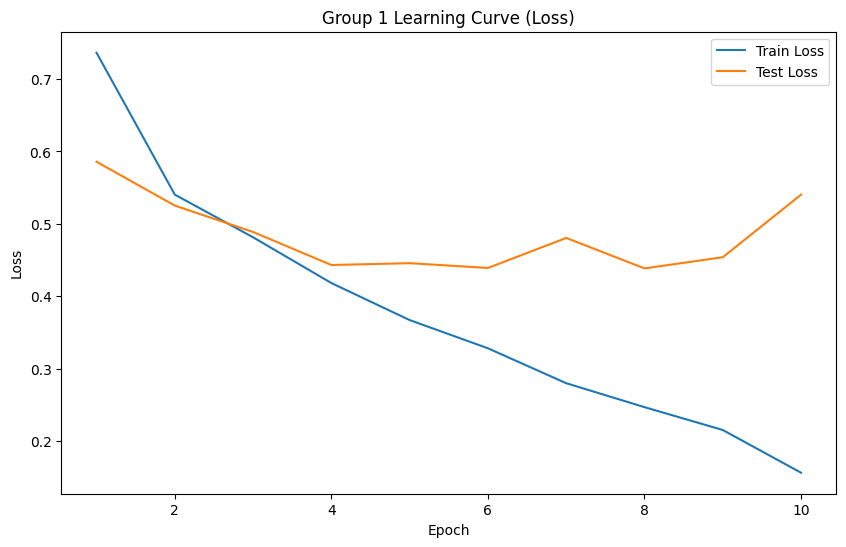

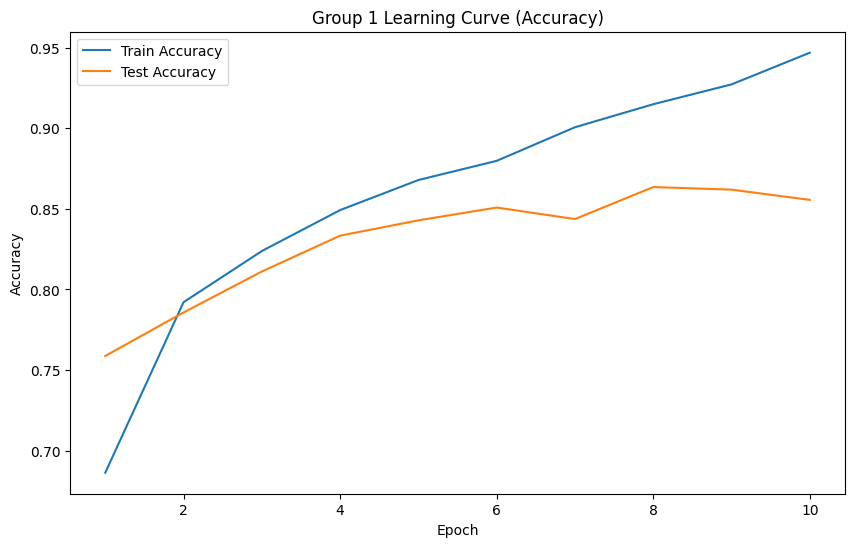

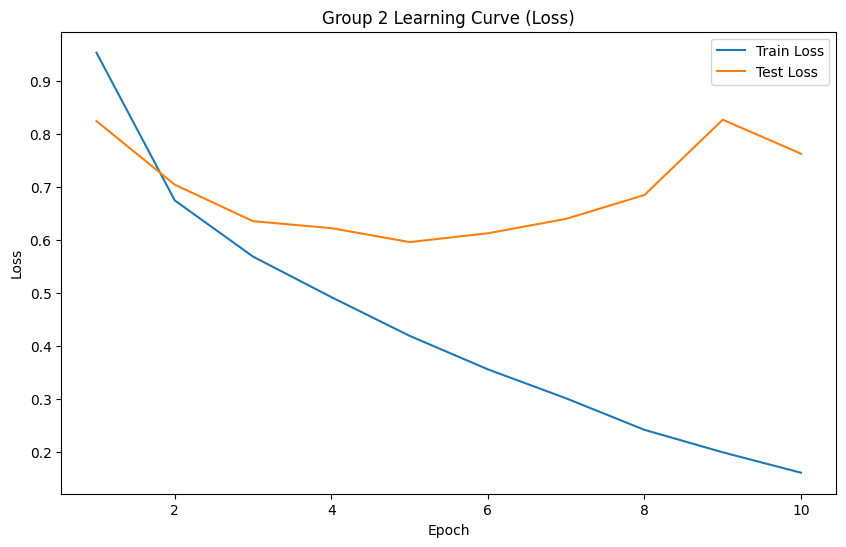

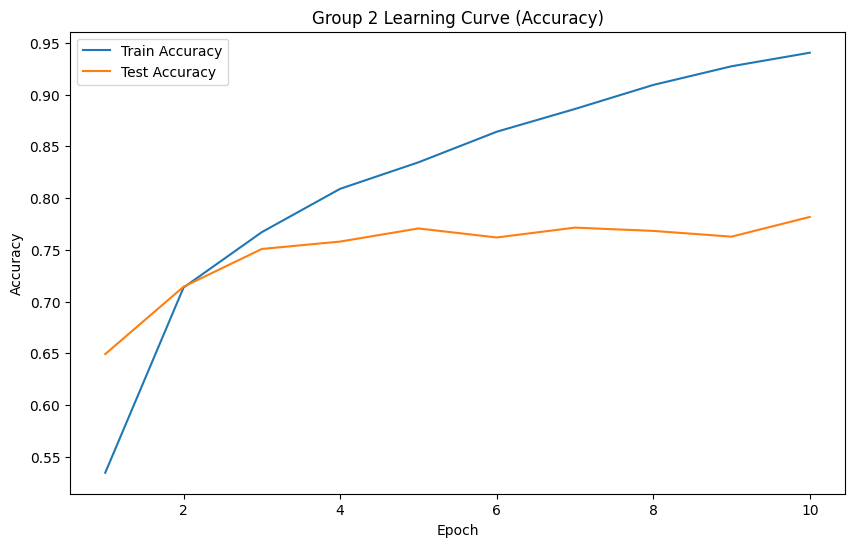

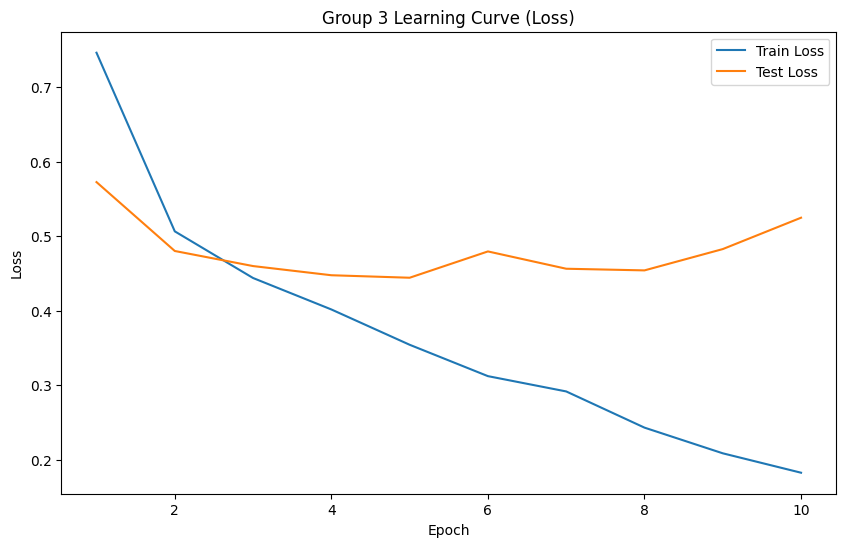

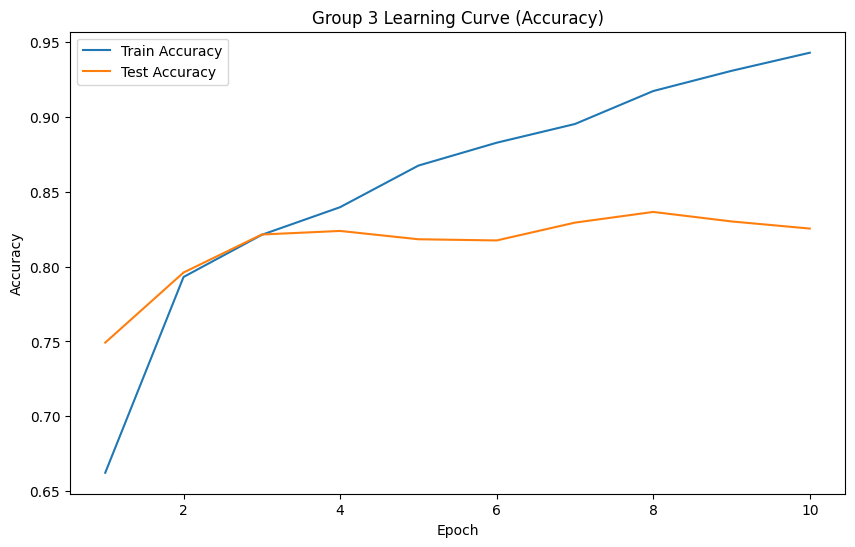

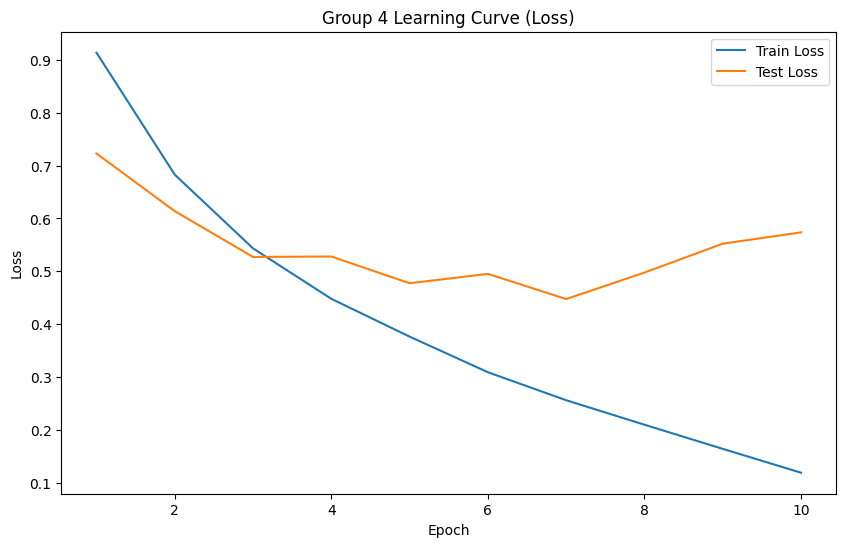

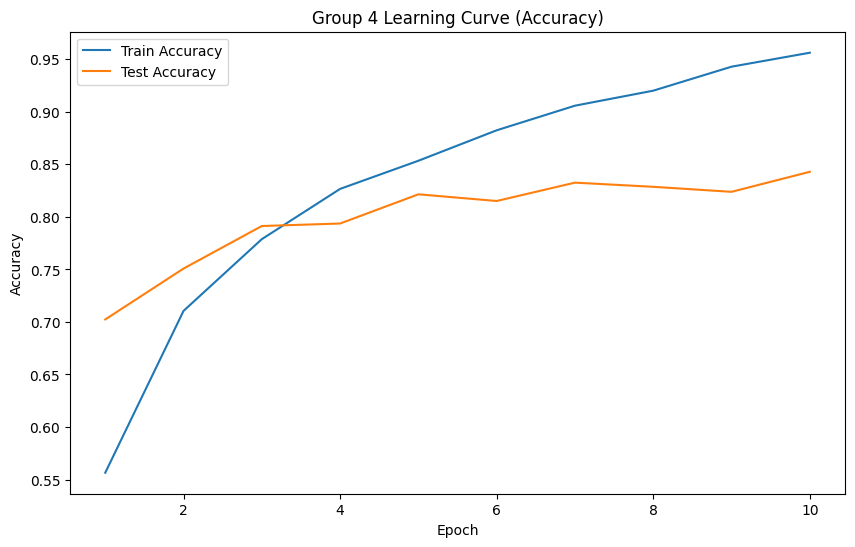

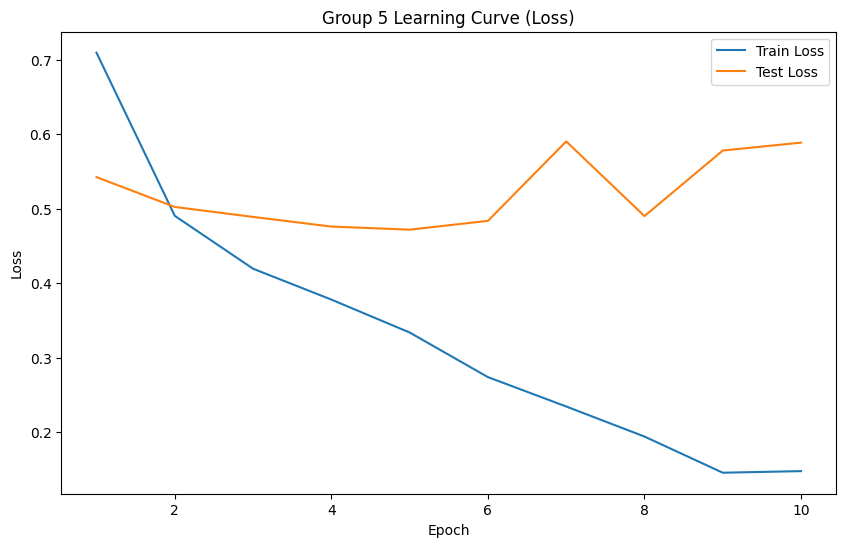

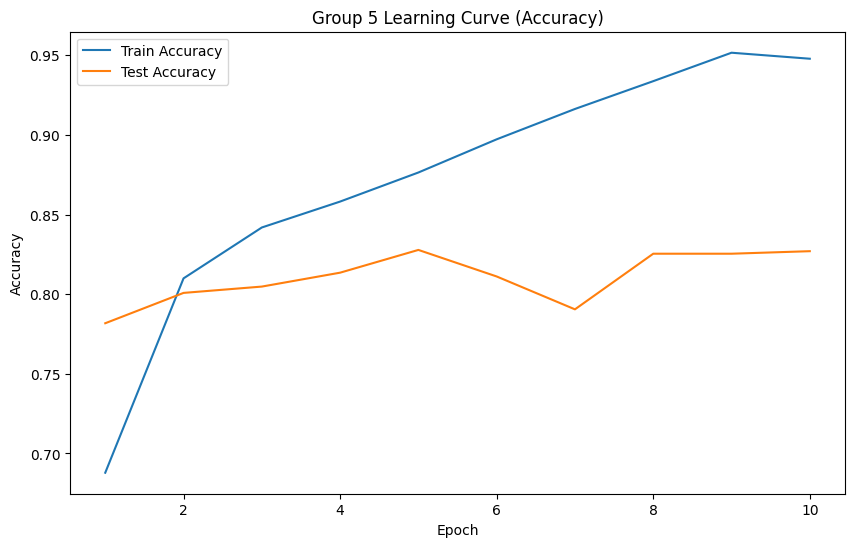

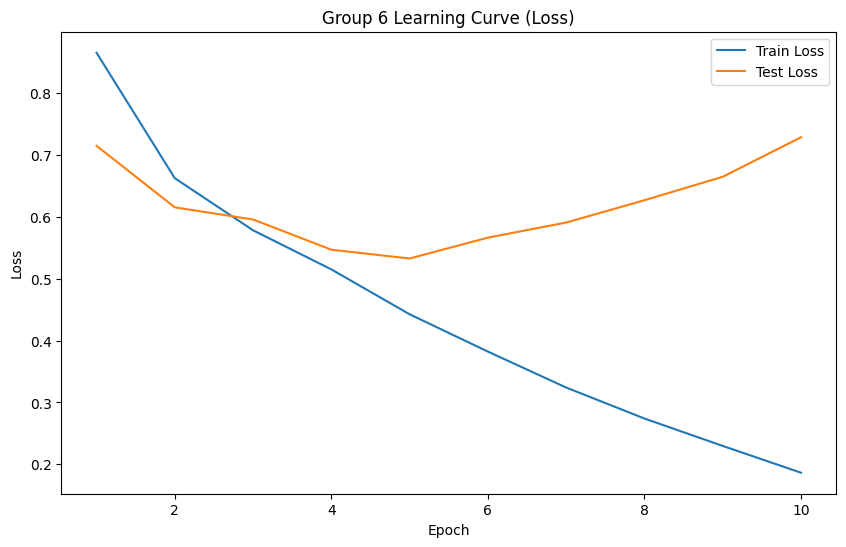

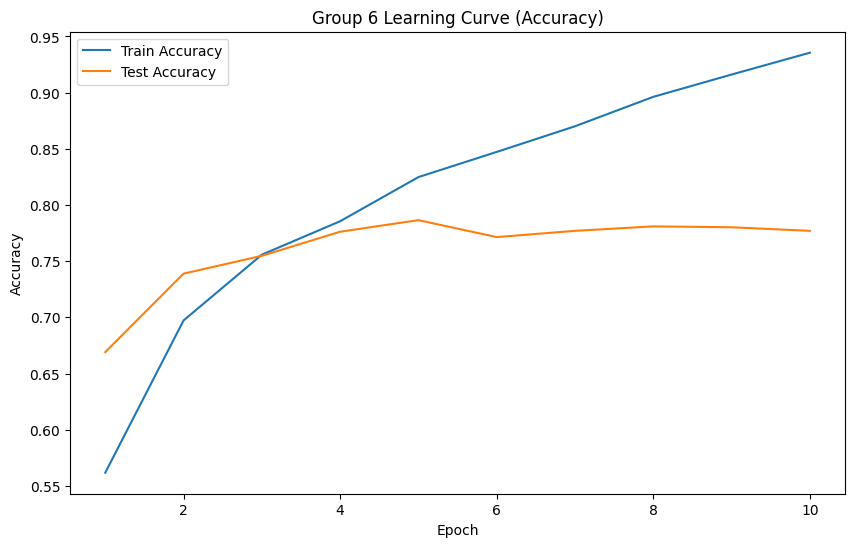

In [11]:
# Learning Curve 그리기
for curve in all_learning_curves:
    group_idx = curve["Group"]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="Test Loss")
    plt.title(f"Group {group_idx} Learning Curve (Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="Train Accuracy")
    plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="Test Accuracy")
    plt.title(f"Group {group_idx} Learning Curve (Accuracy)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


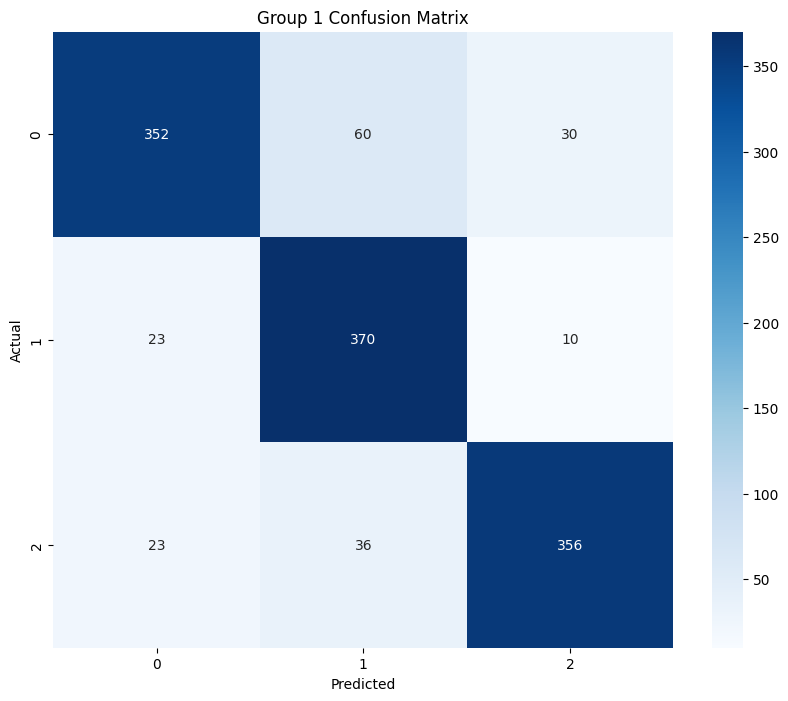

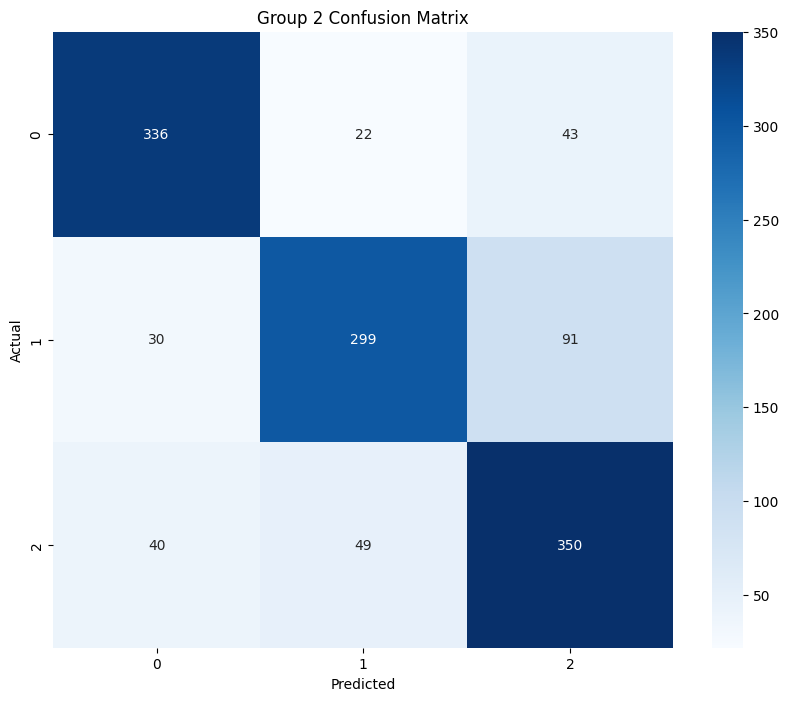

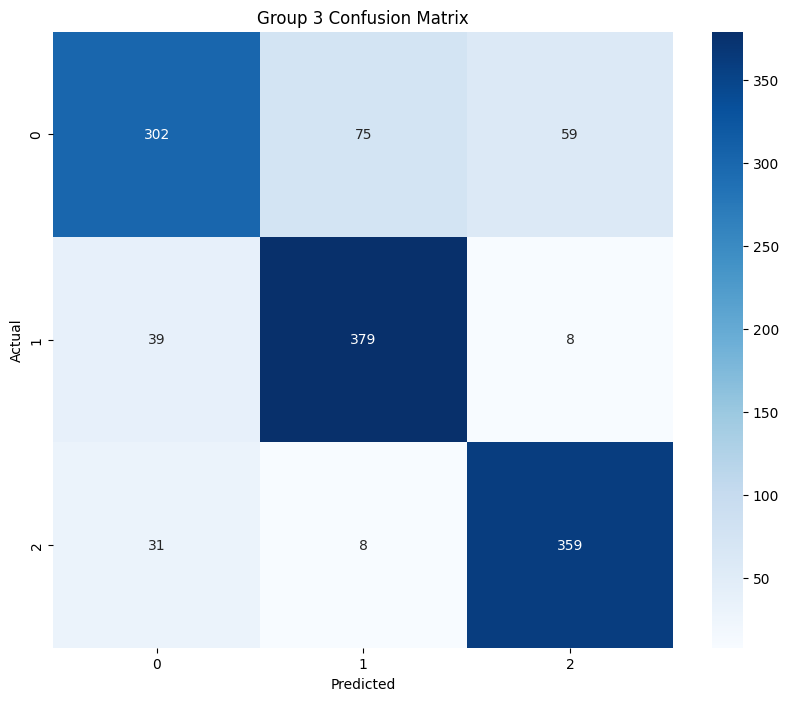

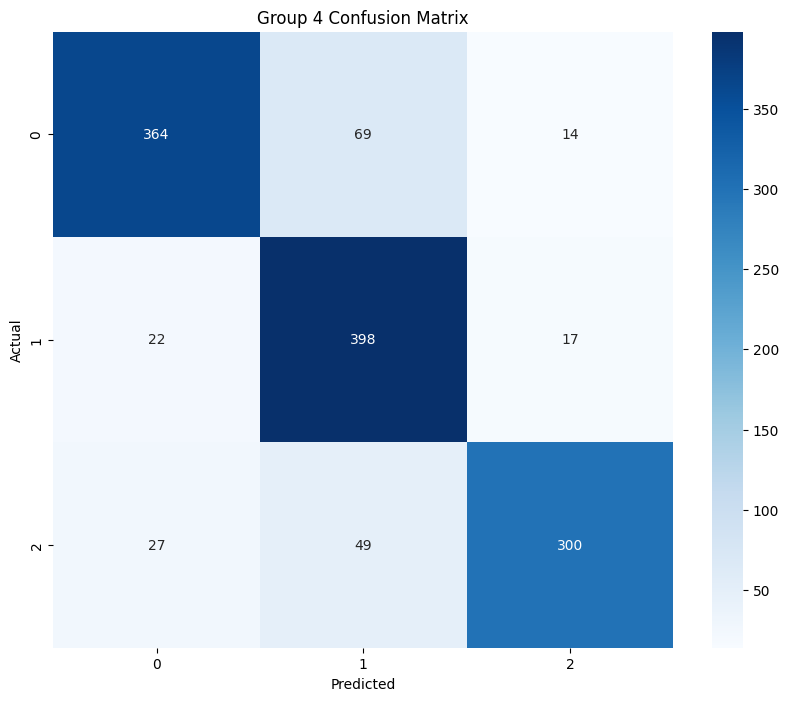

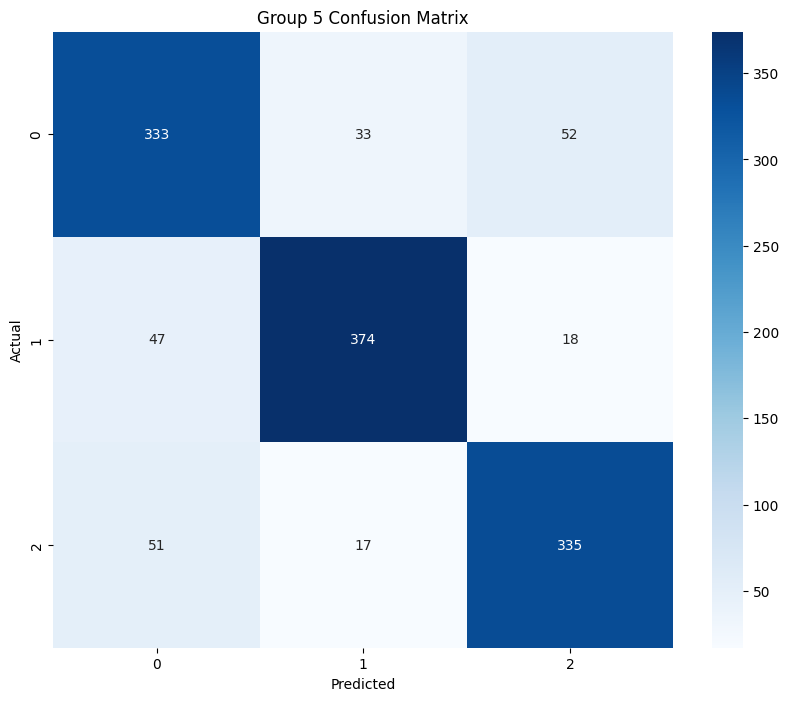

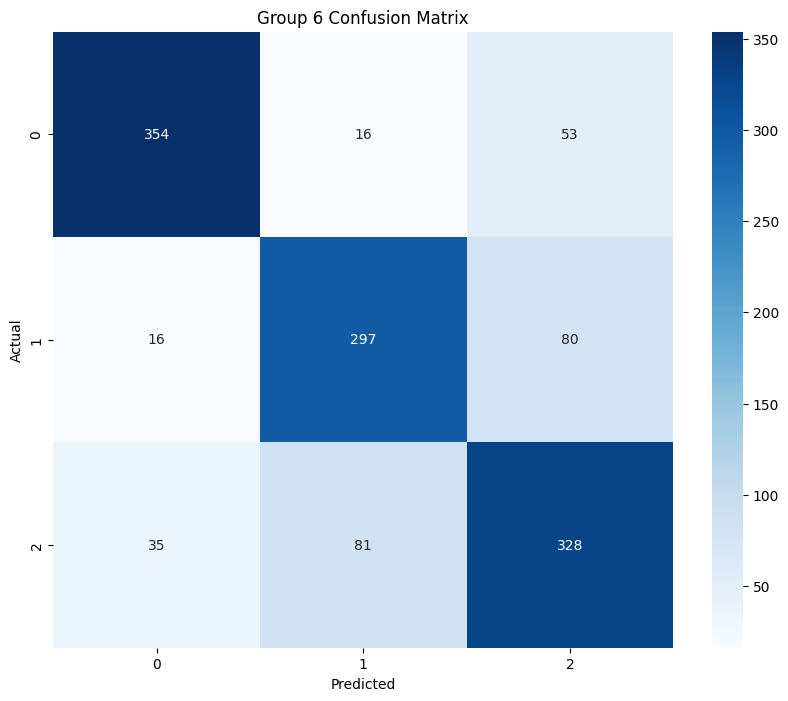

In [12]:
# Confusion Matrix 그리기
for result in results:
    group_idx = result["Group"]
    cm = result["Confusion Matrix"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['Label'].unique()), yticklabels=sorted(df['Label'].unique()))
    plt.title(f"Group {group_idx} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()